In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import cv2

In [90]:
class LCN(nn.Module):
    
    def __init__(self, input_size, simple_number, simple_size, phis_sfs, training_size, phis = True, sfs = False, alpha = 0.0001):
        super(LCN, self).__init__()
        self.input_size = input_size
        self.simple_number = simple_number
        self.simple_size = simple_size
        self.phis_sfs = phis_sfs
        self.phis = phis
        self.sfs = sfs
        
        self.training_size = training_size
        self.alpha = alpha
        self.dimensions = self.input_size - self.simple_size + 1
        
#         self.v4_size = v4_size
#         self.v4_dimensions = self.dimensions - self.v4_size + 1
        
        self.simple_weight = torch.nn.Parameter(self.init_weights())
        
#         self.complex = nn.Linear(
#             self.dimensions*self.dimensions*self.simple_number*self.phis_sfs, 
#             self.dimensions*self.dimensions*self.simple_number)
#         self.complex.weight = torch.nn.Parameter(self.init_complex_weights(), requires_grad = False)

#         self.v4_weight = torch.nn.Parameter(self.init_gaussian_weights(self.v4_size, 3).view(self.simple_number, self.v4_dimensions, self.v4_dimensions, self.v4_size ** 2))
        
        self.decision = nn.Linear(self.dimensions*self.dimensions*self.simple_number, 2)
        self.decision.weight = torch.nn.Parameter(
            torch.zeros((2, self.dimensions*self.dimensions*self.simple_number)))
        
        
    def init_weights(self):
        angles = self.remove_ambiguous_stimuli(0, np.pi, self.simple_number)
        if self.phis == True:
            phis = np.linspace(0, np.pi, self.phis_sfs)
            weights = []
            for i in range(self.simple_number):
                for j in range(self.phis_sfs):
                    for k in range(self.dimensions ** 2):
                        theta = angles[i]
                        phi = phis[j]
                        kernel = self.generate_gabor(self.simple_size, theta, phi, 5)
                        weights.append(kernel)

            weight = torch.stack(weights).view(
                1, self.simple_number*self.phis_sfs, 1, self.dimensions, self.dimensions, self.simple_size ** 2)
            return weight
        if self.sfs == True:
            sfs = np.linspace(1.1, 14, self.phis_sfs)
            weights = []
            for i in range(self.simple_number):
                for j in range(self.phis_sfs):
                    for k in range(self.dimensions ** 2):
                        theta = angles[i]
                        lamda = sfs[j]
                        kernel = self.generate_gabor(self.simple_size, theta, 0, lamda)
                        weights.append(kernel)

            weight = torch.stack(weights).view(
                1, self.simple_number*self.phis_sfs, 1, self.dimensions, self.dimensions, self.simple_size ** 2)
            return weight
    
    def init_gaussian_weights(kernlen, std):
        n = torch.arange(0, kernlen) - (kernlen - 1.0) / 2.0
        sig2 = 2 * std * std
        w = torch.exp(-n ** 2 / sig2)

        gkern1d = gaussian(kernlen, std=std).reshape(kernlen)
        gkern2d = torch.outer(gkern1d, gkern1d)
        return gkern2d

    
    def generate_gabor(self, size, theta, phi, lamda, random_sf = False):
        ksize = size
        sigma = 3
        if random_sf == True:
            lamda = np.random.uniform(1.1, 13)
        gamma = 0.5
        kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lamda, gamma, phi)
        return torch.tensor(kernel).view(1, 1, size, size).float()
    
    def remove_ambiguous_stimuli(self, angle1, angle2, size):
        x = np.linspace(angle1, angle2, size)
        stimuli = [-np.pi/2, 0, np.pi/2, np.pi]
        ambiguous = True
        while ambiguous == True:
            for i in stimuli:
                x = np.where(x == i, i+0.1, x)
            x = np.linspace(x[0], x[-1], size)
            if -np.pi/2 in x or 0 in x or np.pi/2 in x:
                ambiguous = True
            else:
                ambiguous = False
        return x
    
    def binary_loss(self, scores, desired_output):
        loss = nn.CrossEntropyLoss()
        return loss(scores, desired_output)
    
    def inputting(self, angle1, angle2, random_sf):
        
        self.labels = []
        self.inputs = []
    
        x = self.remove_ambiguous_stimuli(angle1, angle2, self.training_size)

        for i in range(self.training_size):
            theta = x[i]
            phi = np.random.uniform(0, np.pi)
            kernel = self.generate_gabor(self.input_size, theta, phi, 5, random_sf = random_sf)
            self.inputs.append(kernel)
            if 0 < theta < np.pi/2:
                label = torch.tensor([0])
            else:
                label = torch.tensor([1])
            self.labels.append(label)
        self.input = torch.stack(self.inputs).view(self.training_size, 1, self.input_size, self.input_size)
        return self.input

    
    def desired_outputting(self):
        self.desired_output = torch.tensor(self.labels)
        return self.desired_output
    
    def forward(self, x):
        x = x.unfold(2, self.simple_size, 1).unfold(3, self.simple_size, 1)
        x = x.contiguous().view(*x.size()[:-2], -1)
        out = (x.unsqueeze(1) * self.simple_weight).sum([2, -1])
        pools = []
        for i in range(0, self.simple_number*self.phis_sfs, self.phis_sfs):
            pool = (torch.sum(out[0][i:i+self.phis_sfs] ** 2, dim = 0)/self.phis_sfs).view(1, self.dimensions, self.dimensions)
            pools.append(pool)
        pools = torch.stack(pools).view(self.simple_number, self.dimensions, self.dimensions)
#         out = pools.unfold(1, self.v4_size, self.v4_stride).unfold(2, self.v4_size, self.v4_stride)
#         out = out.contiguous().view(*out.size()[:-2], -1)
#         out = (out.unsqueeze(1)*self.v4_weight).sum([1, -1])
#         out = out.view(1, self.v4_dimensions*self.v4*dimensions*self.simple_number)
        out = pools.view(1, self.dimensions*self.dimensions*self.simple_number)
        out = self.decision(out)
        return out
    
    def mean_train(self, iterations, optimizer):
        self.before_v1weight = self.simple_weight.clone()
        self.before_w32weight = self.decision.weight.clone()
        
        self.before_v1weights = []
        self.before_w32weights = []
        
        self.losses = []
        self.training_scores = []

        for i in range(iterations):
            optimizer.zero_grad()
            self.training_score = 0
            loss2 = torch.empty(self.training_size)
            
            for j in range(self.training_size):
                
                self.scores = self.forward(self.input[j][0].view(1, 1, self.input_size, self.input_size))
                loss1 = self.binary_loss(self.scores, self.desired_output[j].view(1))
                if torch.argmax(self.scores) == self.desired_output[j]:
                    self.training_score += 1
                loss2[j] = loss1
            
            
            loss = torch.sum(loss2)/self.training_size
            self.losses.append(loss)
            
            self.training_score = self.training_score/self.training_size * 100
            self.training_scores.append(self.training_score)
            
            self.before_v1weights.append(self.v1_weight_change(self.before_v1weight, self.simple_weight))
            self.before_w32weights.append(self.w32_weight_change(self.before_w32weight, self.decision.weight))
            
            loss.backward()
            optimizer.step()
            
    def double_train(self, iterations, optimizer, angle1, angle2, test_angle, test_size):        
        self.before_v1weight = self.simple_weight.clone()
        self.before_w32weight = self.decision.weight.clone()
        
        self.before_v1weights = []
        self.before_w32weights = []
        
        self.losses = []
        self.training_scores = []
        self.generalize_error = []
        self.generalize_perform = []
        for angle in [angle1, angle2]:
            input = self.inputting(-angle, angle, random_sf = False)
            desired_output = self.desired_outputting()
            for i in range(iterations):
                self.training_score = 0
                loss2 = torch.empty(self.training_size)

                for j in range(self.training_size):
                    optimizer.zero_grad()
                    self.scores = self.forward(input[j][0].view(1, 1, self.input_size, self.input_size))
                    loss1 = self.binary_loss(self.scores, desired_output[j].view([1]))
                    if torch.argmax(self.scores) == desired_output[j]:
                        self.training_score += 1
                    loss2[j] = loss1

                loss = torch.sum(loss2)/self.training_size
                self.losses.append(loss)

                self.training_score = self.training_score/self.training_size * 100
                self.training_scores.append(self.training_score)

                generalize = self.generalization(test_angle, test_size)
                self.generalize_error.append(self.general_mean_error)
                self.generalize_perform.append(self.generalization_score)

                self.before_v1weights.append(self.v1_weight_change(self.before_v1weight, self.simple_weight))
                self.before_w32weights.append(self.w32_weight_change(self.before_w32weight, self.decision.weight))

                loss.backward()
                optimizer.step()
    
    def plot_training_error(self, color):
        plt.plot([loss.detach().numpy() for loss in self.losses], color = color)
        plt.xlabel("Time (epochs)")
        plt.ylabel("Error")

    def plot_training_performance(self, color):
        plt.plot(self.training_scores, color = color)
        plt.xlabel("Time (epochs)")
        plt.ylabel("Performance (%)")
        
    def generalization(self, angle, test_size):
        angles = self.remove_ambiguous_stimuli(-angle, angle, test_size)
        self.generalization_score = 0
        general_error = []
        for i in range(test_size):
            gabor = net.generate_gabor(self.input_size, angles[i], phi = 0, lamda = 5).clone().detach()
            if 0 < angles[i] < np.pi/2:
                label = torch.tensor([0])
            else:
                label = torch.tensor([1])
            with torch.no_grad():
                a = self.forward(gabor)
                if torch.argmax(a) == label:
                    self.generalization_score += 1
                general_error.append(self.binary_loss(a, label))
        self.generalization_score = self.generalization_score/test_size * 100
        self.general_mean_error = np.mean(general_error)

    def plot_generalization_performance(self, color):
        plt.plot(self.generalize_perform, color = color)
        plt.xlabel("Time (epochs)")
        plt.ylabel("Performance (%)")

    def plot_generalization_error(self, color):
        plt.plot(self.generalize_error, color = color)
        plt.xlabel("Time (epochs)")
        plt.ylabel("Error")
   
    def plot_angle_performance(self, number, color):
        angles = self.remove_ambiguous_stimuli(0, np.pi/2, number)
        scores = []
        for i in range(number):
            self.generalization(angles[i], 50)
            scores.append(self.generalization_score)
        plt.plot((360 * angles)/(50 * np.pi), scores, color = color)
        plt.xlabel("Separation angle (Degrees)")
        plt.ylabel("Performance (%)")

    def v1_weight_change(self, before, after):
        diff = after - before
        net_diff = []
        for i in diff.view(self.simple_number*self.phis_sfs, 1, self.dimensions, self.dimensions, self.simple_size ** 2):
            for j in i.view(self.dimensions, self.dimensions, self.simple_size ** 2):
                for k in j:
                    net_diff.append(torch.linalg.norm(k.view(self.simple_size, self.simple_size), ord = 'fro').item())
        return np.mean(net_diff)
    
    def w32_weight_change(self, before, after):
        diff = after - before
        net_diff = (torch.linalg.norm(
            diff.view(2, self.dimensions*self.dimensions*self.simple_number), ord = 'fro').item())
        return net_diff
    
    def plot_weight_change(self, color, v1 = False, w32 = False):
        if v1 == True:
            plt.plot(self.before_v1weights, color = color)
        if w32 == True:
            plt.plot(self.before_w32weights, color = color)
        plt.xlabel("Time (epochs)")
        plt.ylabel("Weight change")
    
    def tuning_curve(self):
        x = np.linspace(0, np.pi, 30)
        self.results = torch.empty(self.simple_number, self.phis_sfs, self.dimensions, self.dimensions, len(x))
        self.initial_tuning_curves = torch.empty(
            self.simple_number, self.phis_sfs, self.dimensions, self.dimensions, len(x))
        with torch.no_grad():
            for orientation in range(self.simple_number):
                for sf in range(self.phis_sfs):
                    for horizontal in range(len(self.simple_weight[0][self.phis_sfs * orientation + sf][0])):
                        for vertical in range(
                            len(fixed_net.simple_weight[0][self.phis_sfs * orientation + sf][0][horizontal])):
                            for i in range(len(x)):
                                test = self.generate_gabor(self.simple_size, x[i], 0, 5).view(
                                    self.simple_size, self.simple_size)
                                result = torch.sum(
                                    self.simple_weight[0][self.phis_sfs * orientation + sf][0][horizontal][vertical].view(
                                        self.simple_size, self.simple_size) * test)
                                self.results[orientation][sf][horizontal][vertical][i] = result
                                
                                initial_result = torch.sum(
                                    self.before_v1weight[0][self.phis_sfs * orientation + sf][0][horizontal][vertical].view(
                                        self.simple_size, self.simple_size) * test)
                                self.initial_tuning_curves[orientation][sf][horizontal][vertical][i] = initial_result
                        
    def plot_tuning_curve(self, orientation, sf, position, orientations = False, sfs = False, differences = False):
        x = np.linspace(0, np.pi, 30)
        if orientations == True and differences == False:
            ranges = np.linspace(0, np.pi, self.phis_sfs)
            for i in range(self.simple_number):
                plt.plot(x, self.results[i, sf, position, position, :])
            plt.legend([ranges[i] for i in range(self.phis_sfs)])
                
        if sfs == True and differences == False:
            ranges = np.linspace(1.1, 14, self.phis_sfs)
            for i in range(self.phis_sfs):
                plt.plot(x, self.results[orientation, i, position, position, :])
            plt.legend([ranges[i] for i in range(self.phis_sfs)])
            
        if orientations == True and differences == True:
            ranges = np.linspace(0, np.pi, self.phis_sfs)
            difference = self.results - self.initial_tuning_curves
            print(difference.shape)
            for i in range(self.simple_number):
                plt.plot(x, difference[i, sf, position, position, :])
            plt.legend([ranges[i] for i in range(self.phis_sfs)])
            
        
        if sfs == True and differences == True:
            ranges = np.linspace(0, np.pi, self.phis_sfs)
            difference = self.results - self.initial_tuning_curves
            print(difference.shape)
            for i in range(self.phis_sfs):
                plt.plot(x, difference[orientation, i, position, position, :])
            plt.legend([ranges[i] for i in range(self.phis_sfs)])

        
        
        plt.xlabel("Angle (radians)")
        plt.ylabel("Response")
        


In [29]:
net = LCN(
    input_size = 33, simple_number = 6, simple_size = 11, phis_sfs = 3, training_size = 2, phis = True, sfs = False, alpha = 0.0000007)
x = net.inputting(-np.pi/4, np.pi/4, random_sf = False)
y = net.desired_outputting()
optimizer = optim.SGD(net.parameters(), lr = net.alpha)
net.mean_train(100, optimizer)

net2 = LCN(
    input_size = 33, simple_number = 6, simple_size = 11, phis_sfs = 3, training_size = 2, phis = True, sfs = False, alpha = 0.0000007)
x = net2.inputting(-np.pi/50, np.pi/50, random_sf = False)
y = net2.desired_outputting()
optimizer = optim.SGD(net2.parameters(), lr = net2.alpha)
net2.mean_train(100, optimizer)


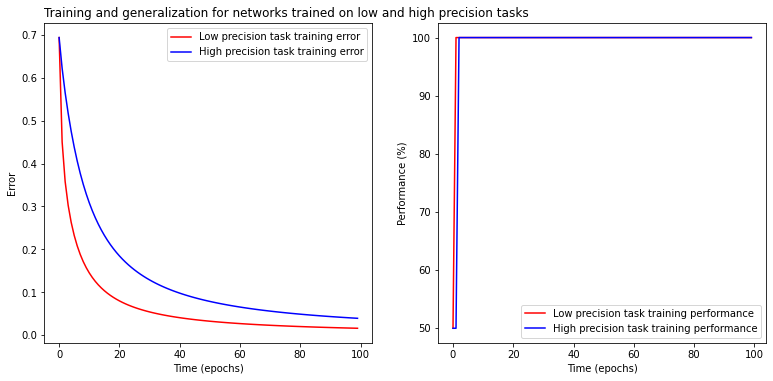

In [30]:
plt.figure(figsize = [20, 20])
plt.subplot(3, 3, 1)
net.plot_training_error('red')
net2.plot_training_error('blue')
plt.legend(["Low precision task training error",
            "High precision task training error"]);
plt.title("Training and generalization for networks trained on low and high precision tasks", loc = "left")

plt.subplot(3, 3, 2)
net.plot_training_performance('red')
net2.plot_training_performance('blue')
plt.legend(["Low precision task training performance",
            "High precision task training performance"]);


In [31]:
net3 = LCN(
    input_size = 33, simple_number = 6, simple_size = 11, phis_sfs = 3, training_size = 2, phis = True, sfs = False, alpha = 0.0000007)
optimizer = optim.SGD(net3.parameters(), lr = net3.alpha)
net3.double_train(50, optimizer, np.pi/4, np.pi/100, np.pi/50, 2)

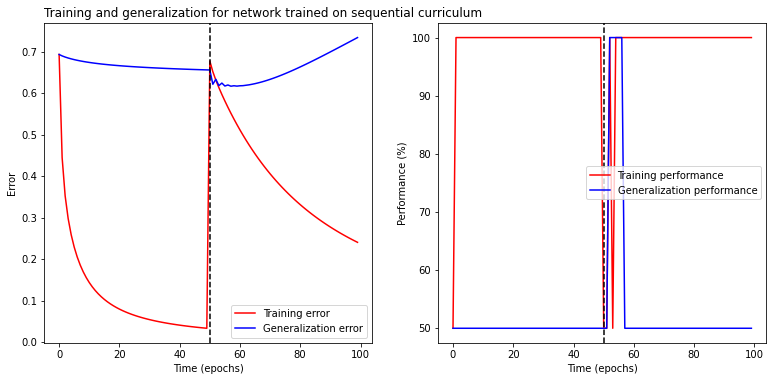

In [32]:
plt.figure(figsize = [20, 20])
plt.subplot(3, 3, 1)
net3.plot_training_error('red')
net3.plot_generalization_error("blue")
plt.axvline(50, 0, 1, linestyle = 'dashed', color = 'black');
plt.legend(["Training error", "Generalization error"]);
plt.title("Training and generalization for network trained on sequential curriculum", loc = "left")

plt.subplot(3, 3, 2)
net3.plot_training_performance('red')
net3.plot_generalization_performance("blue")
plt.legend(["Training performance", "Generalization performance"]);
plt.axvline(50, 0, 1, linestyle = 'dashed', color = 'black');


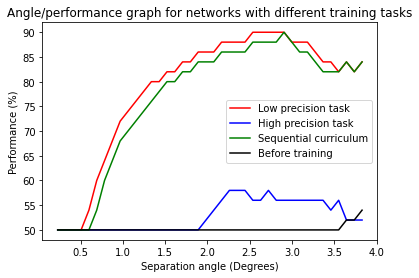

In [24]:
net4 = LCN(
    input_size = 33, simple_number = 6, simple_size = 11, phis_sfs = 3, training_size = 2, phis = True, sfs = False, alpha = 0.0000007)
net.plot_angle_performance(40, 'red')
net2.plot_angle_performance(40, 'blue')
net3.plot_angle_performance(40, 'green')
net4.plot_angle_performance(40, 'black')
plt.legend(["Low precision task", "High precision task", "Sequential curriculum", "Before training"]);
plt.title("Angle/performance graph for networks with different training tasks", loc = 'center');

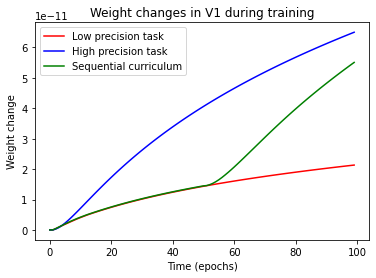

In [27]:
net.plot_weight_change('red', v1 = True)
net2.plot_weight_change('blue', v1 = True)
net3.plot_weight_change('green', v1 = True)
plt.legend(["Low precision task", "High precision task", "Sequential curriculum"]);
plt.title("Weight changes in V1 during training");

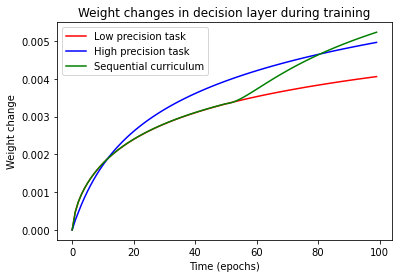

In [28]:
net.plot_weight_change('red', w32 = True)
net2.plot_weight_change('blue', w32 = True)
net3.plot_weight_change('green', w32 = True)
plt.legend(["Low precision task", "High precision task", "Sequential curriculum"]);
plt.title("Weight changes in decision layer during training");

In [93]:
fixed_net = LCN(
    input_size = 33, simple_number = 6, simple_size = 11, phis_sfs = 5, training_size = 2, phis = False, sfs = True, alpha = 0.0000008)
x = fixed_net.inputting(-np.pi/50, np.pi/50, random_sf = False)
y = fixed_net.desired_outputting()
optimizer = optim.SGD(fixed_net.parameters(), lr = fixed_net.alpha)
fixed_net.mean_train(50, optimizer)
fixed_net.tuning_curve()

random_net = LCN(
    input_size = 33, simple_number = 6, simple_size = 11, phis_sfs = 5, training_size = 2, phis = False, sfs = True, alpha = 0.0000008)
x = random_net.inputting(-np.pi/4, np.pi/4, random_sf = True)
y = random_net.desired_outputting()
optimizer = optim.SGD(random_net.parameters(), lr = random_net.alpha)
random_net.mean_train(50, optimizer)
random_net.tuning_curve()

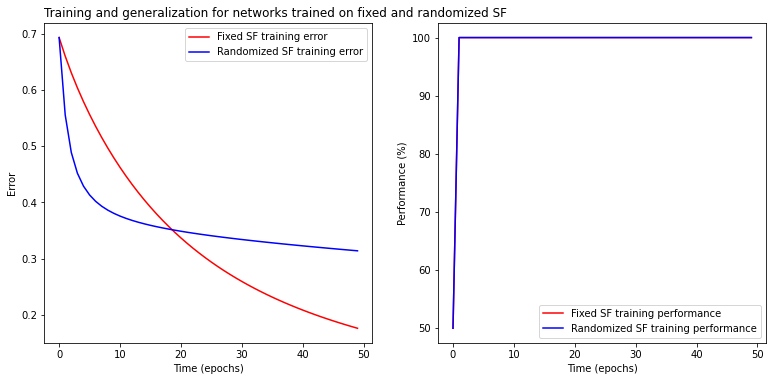

In [313]:
plt.figure(figsize = [20, 20])
plt.subplot(3, 3, 1)
fixed_net.plot_training_error('red')
random_net.plot_training_error('blue')
plt.legend(["Fixed SF training error", "Randomized SF training error"]);
plt.title("Training and generalization for networks trained on fixed and randomized SF", loc = "left")

plt.subplot(3, 3, 2)
fixed_net.plot_training_performance('red')
random_net.plot_training_performance('blue')
plt.legend(["Fixed SF training performance", "Randomized SF training performance"]);


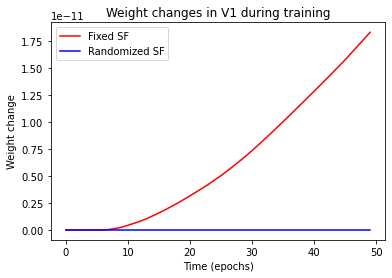

In [80]:
fixed_net.plot_weight_change('red', v1 = True)
random_net.plot_weight_change('blue', v1 = True)
plt.legend(["Fixed SF", "Randomized SF"]);
plt.title("Weight changes in V1 during training");

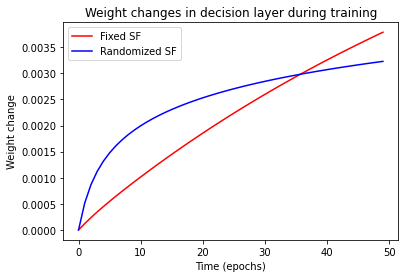

In [81]:
fixed_net.plot_weight_change('red', w32 = True)
random_net.plot_weight_change('blue', w32 = True)
plt.legend(["Fixed SF", "Randomized SF"]);
plt.title("Weight changes in decision layer during training");

torch.Size([6, 5, 23, 23, 30])
torch.Size([6, 5, 23, 23, 30])


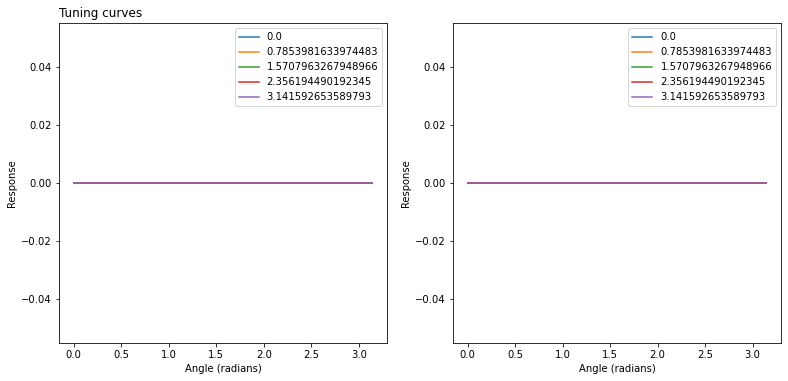

In [94]:
plt.figure(figsize = [20, 20])
plt.subplot(3, 3, 1)
fixed_net.plot_tuning_curve(orientation = 4, sf = 4, position = 12, sfs = True, differences = True)
plt.title("Tuning curves", loc = 'left');

plt.subplot(3, 3, 2)
random_net.plot_tuning_curve(orientation = 4, sf = 4, position = 12, sfs = True, differences = True)


In [236]:
results = []
x = np.linspace(0, np.pi, 30)
with torch.no_grad():
    for sf_orientation in fixed_net.simple_weight[0]:
        for i in x:
            test = fixed_net.generate_gabor(11, i, 0, 5).view(11, 11)
            result = torch.sum(sf_orientation[0][12][12].view(11, 11) * test)
            results.append(result)







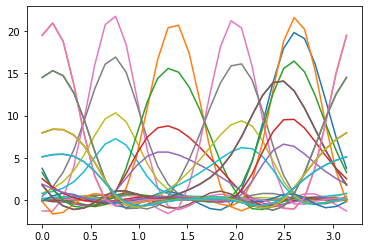

In [239]:
y = np.linspace(0, 900, 31)
for i in range(30):
    plt.plot(x, results[int(y[i]):int(y[i+1])])


In [305]:
results = torch.empty(6, 5, 23, 23, 30)
x = np.linspace(0, np.pi, 30)
with torch.no_grad():
    for orientation in range(6):
        for sf in range(5):
            for horizontal in range(len(fixed_net.simple_weight[0][5 * orientation + sf][0])):
                for vertical in range(len(fixed_net.simple_weight[0][5 * orientation + sf][0][horizontal])):
                    for i in range(len(x)):
                        test = fixed_net.generate_gabor(11, x[i], 0, 5).view(11, 11)
                        result = torch.sum(fixed_net.simple_weight[0][5 * orientation + sf][0][horizontal][vertical].view(11, 11) * test)
                        results[orientation][sf][horizontal][vertical][i] = result

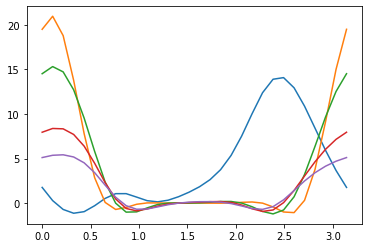

In [310]:
for i in range(5):
    plt.plot(x, results[5, i, 12, 12, :])

In [121]:
input = torch.rand(1, 1, 5, 5)
weight = torch.randn(1, 4, 1, 4, 4, 2**2)
input

tensor([[[[0.7842, 0.0864, 0.8288, 0.7178, 0.4478],
          [0.6102, 0.3597, 0.0960, 0.6444, 0.6689],
          [0.4725, 0.1217, 0.9055, 0.4764, 0.1041],
          [0.8376, 0.7660, 0.2784, 0.8034, 0.6332],
          [0.7009, 0.3847, 0.2182, 0.5453, 0.8565]]]])

In [122]:
weight.shape

torch.Size([1, 4, 1, 4, 4, 4])

In [125]:
output = input.unfold(2, 2, 2).unfold(3, 2, 2)
output2 = output.contiguous().view(*output.size()[:-2],-1)
output2

tensor([[[[[0.7842, 0.0864, 0.6102, 0.3597],
           [0.8288, 0.7178, 0.0960, 0.6444]],

          [[0.4725, 0.1217, 0.8376, 0.7660],
           [0.9055, 0.4764, 0.2784, 0.8034]]]]])

In [38]:
out = (output2.unsqueeze(1) * weight).sum([2,-1])
a = []
for i in range(0, 4, 2):
    a.append(torch.sum(out[0][i:i+2] ** 2, dim = 0))
out, torch.stack(a).view(2, 4, 4)

(tensor([[[[-8.8609e-01,  1.4144e-01,  3.3592e-02,  2.3889e+00],
           [ 6.1357e-01, -2.3320e-03, -9.0398e-01, -6.6459e-02],
           [-1.9733e+00,  5.9907e-01,  6.8793e-01,  2.5147e+00],
           [ 1.1724e+00,  8.3661e-01,  3.2506e-02, -2.4237e-01]],
 
          [[-2.7683e-02,  4.1063e-02,  2.6899e-01,  5.0825e-01],
           [ 1.0065e-01, -3.7913e-01,  1.1162e+00, -1.3634e+00],
           [-1.6172e+00, -2.1688e+00,  5.8416e-01, -5.3280e-01],
           [-1.2030e+00,  2.2461e+00, -7.9992e-01,  1.2372e+00]],
 
          [[-1.2419e+00, -4.5059e-01,  9.7438e-03, -5.9064e-01],
           [-9.5074e-01,  8.0174e-01,  5.6355e-01,  2.4328e+00],
           [ 1.1334e+00, -1.5967e+00, -5.1475e-01,  2.5579e+00],
           [ 7.4123e-01,  1.5458e+00, -1.0115e+00,  4.6402e-01]],
 
          [[ 5.7490e-01, -6.2669e-01,  1.7338e+00, -2.0372e+00],
           [-8.2743e-01, -4.2821e-02, -4.2092e-01,  6.8354e-02],
           [ 1.3654e-01,  1.1119e+00,  6.6431e-01,  1.9692e-02],
           [ 2.0

In [194]:
weight.sum([2,-1])

tensor([[[[ 0.2409,  1.1685],
          [ 0.6973, -0.3850]]]])

In [348]:
def generate_gabor(size, theta):
    ksize = size
    sigma = 3
    lamda = 5
    gamma = 0.5
    phi = 0
    kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lamda, gamma, phi)
    return torch.tensor(kernel).view(1, 1, size, size).float()

angles = np.linspace(0, np.pi, 6)
weights = []
for i in range(6):
    for j in range(49):
        theta = angles[i]
        kernel = generate_gabor(5, theta)
        weights.append(kernel)
weight = torch.stack(weights).view(1, 6, 1, 7, 7, 25)
weights

[tensor([[[[-0.6128,  0.2765,  0.9460,  0.2765, -0.6128],
           [-0.6389,  0.2883,  0.9862,  0.2883, -0.6389],
           [-0.6478,  0.2923,  1.0000,  0.2923, -0.6478],
           [-0.6389,  0.2883,  0.9862,  0.2883, -0.6389],
           [-0.6128,  0.2765,  0.9460,  0.2765, -0.6128]]]]),
 tensor([[[[-0.6128,  0.2765,  0.9460,  0.2765, -0.6128],
           [-0.6389,  0.2883,  0.9862,  0.2883, -0.6389],
           [-0.6478,  0.2923,  1.0000,  0.2923, -0.6478],
           [-0.6389,  0.2883,  0.9862,  0.2883, -0.6389],
           [-0.6128,  0.2765,  0.9460,  0.2765, -0.6128]]]]),
 tensor([[[[-0.6128,  0.2765,  0.9460,  0.2765, -0.6128],
           [-0.6389,  0.2883,  0.9862,  0.2883, -0.6389],
           [-0.6478,  0.2923,  1.0000,  0.2923, -0.6478],
           [-0.6389,  0.2883,  0.9862,  0.2883, -0.6389],
           [-0.6128,  0.2765,  0.9460,  0.2765, -0.6128]]]]),
 tensor([[[[-0.6128,  0.2765,  0.9460,  0.2765, -0.6128],
           [-0.6389,  0.2883,  0.9862,  0.2883, -0.6389],
  

In [345]:

inputs = []

x = np.linspace(0, np.pi, 10)

for i in range(1):
    theta = x[i]
    kernel = generate_gabor(11, theta)
    inputs.append(kernel)

input = torch.stack(inputs).view(1, 1, 11, 11)
output = input.unfold(2, 5, 1).unfold(3, 5, 1)
output2 = output.contiguous().view(*output.size()[:-2],-1)
out = (output2.unsqueeze(1) * weight).sum([2,-1])
output2.shape

torch.Size([1, 1, 7, 7, 25])

In [233]:
np.linspace(0, np.pi, 3), np.pi/2

(array([0.        , 1.57079633, 3.14159265]), 1.5707963267948966)

In [74]:
m = nn.MaxPool2d((2,2), stride = (2,2))
input = torch.rand(1, 1, 5, 5)
input, m(input)

(tensor([[[[0.2895, 0.7121, 0.9417, 0.2207, 0.6506],
           [0.6913, 0.7290, 0.3796, 0.9106, 0.9665],
           [0.4800, 0.3665, 0.2166, 0.1707, 0.6151],
           [0.8305, 0.9675, 0.4218, 0.2555, 0.2691],
           [0.5126, 0.7091, 0.1010, 0.7505, 0.5868]]]]),
 tensor([[[[0.7290, 0.9417],
           [0.9675, 0.4218]]]]))

In [305]:
for i in range(0, 10, 2):
    print(i)

0
2
4
6
8


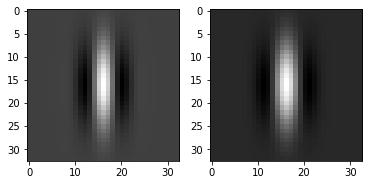

In [14]:
fig, [ax1, ax2] = plt.subplots(1, 2)
ksize = 33
sigma = 3
lamda = 10
gamma = 0.5
phi = 0
theta = 0
kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lamda, gamma, phi)
ax1.imshow(kernel, 'gray')


ksize = 33
sigma = 3
lamda = 13
gamma = 0.5
phi = 0
theta = 0
kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lamda, gamma, phi)
ax2.imshow(kernel, 'gray')

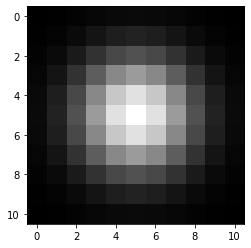

tensor([[0.0019, 0.0059, 0.0143, 0.0266, 0.0388, 0.0439, 0.0388, 0.0266, 0.0143,
         0.0059, 0.0019],
        [0.0059, 0.0183, 0.0439, 0.0821, 0.1194, 0.1353, 0.1194, 0.0821, 0.0439,
         0.0183, 0.0059],
        [0.0143, 0.0439, 0.1054, 0.1969, 0.2865, 0.3247, 0.2865, 0.1969, 0.1054,
         0.0439, 0.0143],
        [0.0266, 0.0821, 0.1969, 0.3679, 0.5353, 0.6065, 0.5353, 0.3679, 0.1969,
         0.0821, 0.0266],
        [0.0388, 0.1194, 0.2865, 0.5353, 0.7788, 0.8825, 0.7788, 0.5353, 0.2865,
         0.1194, 0.0388],
        [0.0439, 0.1353, 0.3247, 0.6065, 0.8825, 1.0000, 0.8825, 0.6065, 0.3247,
         0.1353, 0.0439],
        [0.0388, 0.1194, 0.2865, 0.5353, 0.7788, 0.8825, 0.7788, 0.5353, 0.2865,
         0.1194, 0.0388],
        [0.0266, 0.0821, 0.1969, 0.3679, 0.5353, 0.6065, 0.5353, 0.3679, 0.1969,
         0.0821, 0.0266],
        [0.0143, 0.0439, 0.1054, 0.1969, 0.2865, 0.3247, 0.2865, 0.1969, 0.1054,
         0.0439, 0.0143],
        [0.0059, 0.0183, 0.0439, 0.08

In [76]:
def gaussian(M, std):
    n = torch.arange(0, M) - (M - 1.0) / 2.0
    sig2 = 2 * std * std
    w = torch.exp(-n ** 2 / sig2)
    return w

def gkern(kernlen=256, std=128):
    """Returns a 2D Gaussian kernel array."""
    gkern1d = gaussian(kernlen, std=std).reshape(kernlen)
    gkern2d = torch.outer(gkern1d, gkern1d)
    return gkern2d

# Test plot
plt.figure()
plt.imshow(gkern(11, std=2), 'gray')
plt.show()
gkern(11, 2)

In [195]:
# input number: 1, input size: 3x3, weight size: 2x2, weight number 2
x = torch.rand(1, 3, 3)
weight = torch.rand(1, 2, 2, 4)
y = x.unfold(1, 2, 1).unfold(2, 2, 1)
z = y.contiguous().view(*y.size()[:-2], -1)
out = (z.unsqueeze(1)*weight).sum([1, -1])
out.shape

torch.Size([1, 2, 2])

In [ ]:
class LCN(nn.Module):
    
    def __init__(self, input_size, simple_number, simple_size, phis, training_size, alpha = 0.0001):
        super(LCN, self).__init__()
        self.input_size = input_size
        self.simple_number = simple_number
        self.simple_size = simple_size
        self.phis = phis
        self.training_size = training_size
        self.alpha = alpha
        self.dimensions = self.input_size - self.simple_size + 1
        
        
        self.simple_weight = torch.nn.Parameter(self.init_weights())
        

        
        self.decision = nn.Linear(self.dimensions*self.dimensions*self.simple_number, 2)
        self.decision.weight = torch.nn.Parameter(
            torch.zeros((2, self.dimensions*self.dimensions*self.simple_number)))
        
        
    def init_weights(self):
        angles = self.remove_ambiguous_stimuli(0, np.pi, self.simple_number)
        phis = np.linspace(0, np.pi, self.phis)
        weights = []
        for i in range(self.simple_number):
            for j in range(self.phis):
                for k in range(self.dimensions ** 2):
                    theta = angles[i]
                    phi = phis[j]
                    kernel = self.generate_gabor(self.simple_size, theta, phi)
                    weights.append(kernel)
                
        weight = torch.stack(weights).view(
            1, self.simple_number*self.phis, 1, self.dimensions, self.dimensions, self.simple_size ** 2)
        return weight
    
    def generate_gabor(self, size, theta, phi):
        ksize = size
        sigma = 3
        lamda = 5
        gamma = 0.5
        kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lamda, gamma, phi)
        return torch.tensor(kernel).view(1, 1, size, size).float()
    
    def remove_ambiguous_stimuli(self, angle1, angle2, size):
        x = np.linspace(angle1, angle2, size)
        stimuli = [-np.pi/2, 0, np.pi/2, np.pi]
        ambiguous = True
        while ambiguous == True:
            for i in stimuli:
                x = np.where(x == i, i+0.1, x)
            x = np.linspace(x[0], x[-1], size)
            if -np.pi/2 in x or 0 in x or np.pi/2 in x:
                ambiguous = True
            else:
                ambiguous = False
        return x
    
    def binary_loss(self, scores, desired_output):
        loss = nn.CrossEntropyLoss()
        return loss(scores, desired_output)
    
    def inputting(self, angle1, angle2):
        
        self.labels = []
        self.inputs = []
    
        x = self.remove_ambiguous_stimuli(angle1, angle2, self.training_size)

        for i in range(self.training_size):
            theta = x[i]
            kernel = self.generate_gabor(self.input_size, theta, phi = 0)
            self.inputs.append(kernel)
            if 0 < theta < np.pi/2:
                label = torch.tensor([0])
            else:
                label = torch.tensor([1])
            self.labels.append(label)
        self.input = torch.stack(self.inputs).view(self.training_size, 1, self.input_size, self.input_size)
        return self.input
    
    def desired_outputting(self):
        self.desired_output = torch.tensor(self.labels)
        return self.desired_output
    
    def forward(self, x):
        x = x.unfold(2, self.simple_size, 1).unfold(3, self.simple_size, 1)
        x = x.contiguous().view(*x.size()[:-2], -1)
        out = (x.unsqueeze(1) * self.simple_weight).sum([2, -1])
        pools = []
        for i in range(0, self.simple_number*self.phis, self.phis):
            pool = torch.mean(out[0][i:i+self.phis], dim = 0).view(1, self.dimensions, self.dimensions)
            pools.append(pool)
        pools = torch.stack(pools).view(self.simple_number, self.dimensions, self.dimensions)
        out = pools.view(1, self.dimensions*self.dimensions*self.simple_number)
        out = self.decision(out)
        return out
    
    def mean_train(self, iterations, optimizer):
        self.before_v1weight = self.simple_weight.clone()
        self.before_w32weight = self.decision.weight.clone()
        
        self.before_v1weights = []
        self.before_w32weights = []
        
        self.losses = []
        self.training_scores = []

        for i in range(iterations):
            optimizer.zero_grad()
            self.training_score = 0
            loss2 = []
            
            for j in range(self.training_size):
                
                self.scores = self.forward(self.input[j][0].view(1, 1, self.input_size, self.input_size))
                loss1 = self.binary_loss(self.scores, self.desired_output[j].view(1))
                if torch.argmax(self.scores) == self.desired_output[j]:
                    self.training_score += 1
                loss2.append(loss1)
                
            loss = np.sum(loss2)/self.training_size
            self.losses.append(loss)
            
            self.training_score = self.training_score/self.training_size * 100
            self.training_scores.append(self.training_score)
            
            self.before_v1weights.append(self.v1_weight_change(self.before_v1weight, self.simple_weight))
            self.before_w32weights.append(self.w32_weight_change(self.before_w32weight, self.decision.weight))
            
            loss.backward()
            optimizer.step()
            
    def double_train(self, iterations, optimizer, angle1, angle2, test_angle, test_size):        
        self.before_v1weight = self.simple_weight.clone()
        self.before_w32weight = self.decision.weight.clone()
        
        self.before_v1weights = []
        self.before_w32weights = []
        
        self.losses = []
        self.training_scores = []
        self.generalize_error = []
        self.generalize_perform = []
        for angle in [angle1, angle2]:
            input = self.inputting(-angle, angle)
            desired_output = self.desired_outputting()
            for i in range(iterations):
                self.training_score = 0
                loss2 = []

                for j in range(self.training_size):
                    optimizer.zero_grad()
                    self.scores = self.forward(input[j][0].view(1, 1, self.input_size, self.input_size))
                    loss1 = self.binary_loss(self.scores, desired_output[j].view([1]))
                    if torch.argmax(self.scores) == desired_output[j]:
                        self.training_score += 1
                    loss2.append(loss1)

                loss = np.sum(loss2)/self.training_size
                self.losses.append(loss)

                self.training_score = self.training_score/self.training_size * 100
                self.training_scores.append(self.training_score)

                generalize = self.generalization(test_angle, test_size)
                self.generalize_error.append(self.general_mean_error)
                self.generalize_perform.append(self.generalization_score)

                self.before_v1weights.append(self.v1_weight_change(self.before_v1weight, self.simple_weight))
                self.before_w32weights.append(self.w32_weight_change(self.before_w32weight, self.decision.weight))

                loss.backward()
                optimizer.step()
    
    def plot_training_error(self, color):
        plt.plot(self.losses, color = color)
        plt.xlabel("Time (epochs)")
        plt.ylabel("Error")

    def plot_training_performance(self, color):
        plt.plot(self.training_scores, color = color)
        plt.xlabel("Time (epochs)")
        plt.ylabel("Performance (%)")
        
    def generalization(self, angle, test_size):
        angles = self.remove_ambiguous_stimuli(-angle, angle, test_size)
        self.generalization_score = 0
        general_error = []
        for i in range(test_size):
            gabor = net.generate_gabor(self.input_size, angles[i], phi = 0).clone().detach()
            if 0 < angles[i] < np.pi/2:
                label = torch.tensor([0])
            else:
                label = torch.tensor([1])
            with torch.no_grad():
                a = self.forward(gabor)
                if torch.argmax(a) == label:
                    self.generalization_score += 1
                general_error.append(self.binary_loss(a, label))
        self.generalization_score = self.generalization_score/test_size * 100
        self.general_mean_error = np.mean(general_error)

    def plot_generalization_performance(self, color):
        plt.plot(self.generalize_perform, color = color)
        plt.xlabel("Time (epochs)")
        plt.ylabel("Performance (%)")

    def plot_generalization_error(self, color):
        plt.plot(self.generalize_error, color = color)
        plt.xlabel("Time (epochs)")
        plt.ylabel("Error")
   
    def plot_angle_performance(self, number, color):
        angles = self.remove_ambiguous_stimuli(0, np.pi/2, number)
        scores = []
        for i in range(number):
            self.generalization(angles[i], 50)
            scores.append(self.generalization_score)
        plt.plot((360 * angles)/(50 * np.pi), scores, color = color)
        plt.xlabel("Separation angle (Degrees)")
        plt.ylabel("Performance (%)")

    def v1_weight_change(self, before, after):
        diff = after - before
        net_diff = []
        for i in diff.view(self.simple_number*self.phis, 1, self.dimensions, self.dimensions, self.simple_size ** 2):
            for j in i.view(self.dimensions, self.dimensions, self.simple_size ** 2):
                for k in j:
                    net_diff.append(torch.linalg.norm(k.view(self.simple_size, self.simple_size), ord = 'fro').item())
        return np.mean(net_diff)
    
    def w32_weight_change(self, before, after):
        diff = after - before
        net_diff = (torch.linalg.norm(
            diff.view(2, self.dimensions*self.dimensions*self.simple_number), ord = 'fro').item())
        return net_diff
    
    def plot_weight_change(self, color, v1 = False, w32 = False):
        if v1 == True:
            plt.plot(self.before_v1weights, color = color)
        if w32 == True:
            plt.plot(self.before_w32weights, color = color)
        plt.xlabel("Time (epochs)")
        plt.ylabel("Weight change")